# Goal
* Three examples of Hyperparameter optimization with deep learning:
  * Commercial building power consumption forcasting
  * Image classification
    * CFAR10
    * CFAR100
    * MNIST Handwritten digits
  * Weather forcasting
    * Maybe kaggle?
    * pug
  
## Secondary goal
* Get hyperopt integrated with scikit-learn

## Strategy
* Choose well known data sets (see scikit or skdata)
* Get basic model up and running (baseline)
* Add hyperopt or other param search
* Compare results
* Add in NN (maybe for feature selection?)

## Next step
* Create benchmark
  * On NN lib
    * Sklearn
    * keras
  * On param search techniques
    * sklearn
      * grid search
      * random search
  * on data sets
    * sklearn
    * skdata
    * keras
    
## Relevant links
* [optimizing params with hyperopt](http://fastml.com/optimizing-hyperparams-with-hyperopt/)
* [automatic hyperparam tuning methods](http://www.johnmyleswhite.com/notebook/2012/07/21/automatic-hyperparameter-tuning-methods/)

# MNIST Digit classifier
## Keras

Keras has the MNIST data set as well as an example CNN script [here](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) (keras also has an mlp and irnn script).

Running the cnn script takes *way* too long on my computer.

## Scikit
In light of the keras NNs taking too long to run, as well as the added complexity of training NNs, i've decided to first work with some simple classifiers and stack the hyperparameter optimizers on top before I add another layer of complexity that comes with NNs. Furthermore, this might help us separate the performance gains coming from just the optimizers as opposed to introducing NNs.

Scikit has some form of the MNIST dataset as well [here](https://scikit-learn.github.io/dev/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits).

Furthermore, scikit has a number of examples about using hyperparam optimizers on digit recognizing classifiers (even an example about using a restricted boltzmann machine for feature selection). I should get some of these up and running to establish a baseline.

Idea: Could I get hyperopt working on some of these examples as well? If I can run examples using grid and random search, then I could use that as a hyperparam tuning baseline and compare using hyperopt and other libs as well.

### Relevant Links
* [Recognizing handwritten digits with svm](https://scikit-learn.github.io/dev/auto_examples/classification/plot_digits_classification.html)
* [Parameter estimation using grid search with cross-validation and svc](https://scikit-learn.github.io/dev/auto_examples/model_selection/grid_search_digits.html#example-model-selection-grid-search-digits-py)
* [Restricted Boltzmann Machine features for digit classification using logistic regression](https://scikit-learn.github.io/dev/auto_examples/neural_networks/plot_rbm_logistic_classification.html#example-neural-networks-plot-rbm-logistic-classification-py)  # NOTE: The params were found previously using gridsearch.
* [Comparing randomized search and grid search for hyperparameter estimation using random forest](https://scikit-learn.github.io/dev/auto_examples/model_selection/randomized_search.html#example-model-selection-randomized-search-py)
* [Overview on Grid Search: Searching for estimator parameters](https://scikit-learn.github.io/dev/modules/grid_search.html#grid-search)
* [Overview on Randomized Search](https://scikit-learn.github.io/dev/modules/generated/sklearn.grid_search.RandomizedSearchCV.html#sklearn.grid_search.RandomizedSearchCV)

### Logistic Regression with Grid Search and Random Search

I ran this on the original sklearn data set but since the set was so small, the hyperparameter optimizers didn't do much to improve.

In [2]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation as cval
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import classification_report

from time import time
from operator import itemgetter

import numpy as np
from scipy.stats import randint as sp_randint


# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
# Initialize the data        

digits = datasets.load_digits()

X_train, X_test, y_train, y_test = cval.train_test_split(digits.data, digits.target, test_size=0.3, random_state=0)

# Logistic regression without hyperparameter optimization

logit = LogisticRegression()

start = time()
logit.fit(X_train, y_train)
#logit.score(X_test, y_test)

print("============= Logistic Regression =============")
print("Logistic regression took %.2f seconds."
      % (time() - start))
print
print(classification_report(y_test, logit.predict(X_test)))

# Define parameter space to search over
# Note: GridSearch uses ParameterGrid method which does NOT interpolate between values.
# See grid_search.ParameterSampler for a random distribution sampler.
# Note: Use logit.get_params() to see default params.


"""
param_dist = {"C":[0.1,2],
              "intercept_scaling":[.02,2],
              "max_iter":[50],
              "tol":[0.00001,0.001]
             }
"""

C_param = list(np.linspace(0.1,2,5))
iter_num = [100]
inter_scale = list(np.linspace(0.1,1,5))

param_dist = {"C":[.5,1,1.5],
              "intercept_scaling":inter_scale,
              "max_iter":iter_num,
              "tol":[.0001],
              "penalty":['l1'],
              "class_weight":[None]
             }
# Initialize grid search

#grid_search = GridSearchCV(logit, param_dist)
grid_search = GridSearchCV(logit, param_grid=param_dist)

# Run grid search and check results
start = time()
grid_search.fit(X_train, y_train)

print("============= Grid Search =============")
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

print("Best parameters set found on development set:")
print
print(grid_search.best_params_)
print
print("Grid scores on development set:")
print
for params, mean_score, scores in grid_search.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print()

print("Detailed classification report:")
print
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))
print

# Random Search

rand_C_param = sp_randint(1,3)

rand_param_dist = {"C":sp_randint(1,3),           # Want range(0.5,1.5)
              "intercept_scaling":inter_scale,
              "max_iter":iter_num,
              "tol":[0.001],
              "penalty":['l1'],
              "class_weight":[None]
             }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(logit, param_distributions=rand_param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("============= Random Search =============")
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

============= Logistic Regression =============
Logistic regression took 0.76 seconds.

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        45
          1       0.88      0.88      0.88        52
          2       0.96      0.96      0.96        53
          3       0.93      0.96      0.95        54
          4       0.98      1.00      0.99        48
          5       0.98      0.96      0.97        57
          6       0.95      0.98      0.97        60
          7       1.00      0.94      0.97        53
          8       0.90      0.90      0.90        61
          9       0.95      0.93      0.94        57

avg / total       0.95      0.95      0.95       540

============= Grid Search =============
GridSearchCV took 64.44 seconds for 15 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.955 (std: 0.004)
Parameters: {'C': 0.5, 'intercept_scaling': 0.10000000000000001, 'max_iter': 100, 'penalty': 'l1', 'tol

## Benchmarking methods

* Question: I'm confused about how to benchmark hyperparam opts against non-hyperparam opt problems since (my **assumption** is that) in the non-hyperparam case, our choice of initial hyperparameters is arbitrary and therefore arbitrarily good or bad. In the case of the above logit regression with or without hyperparam opts, we found very little change by adding the hyperparam opts in suggesting (another **assumption**:) that the logit regression was already close to global optimum. 
  * Remark: If our solution space is convex, I would imagine that we wouldn't get much of an improvement from a hyperparam opt.
  * Working solution: Try simple convex and non-convex functions. Can I make the initial guess of parameters bad?
  
### How does Bergstra benchmark hyperopt?
* Bergstra benchmarked his hyperopt using HPOLib (which is part of the AutoML lib). 
  * [Bergstra's paper](http://compneuro.uwaterloo.ca/files/publications/bergstra.2014.pdf)
  * [HPOLib](http://www.automl.org/hpolib)
  * [List of benchmarks used by HPOLib](http://www.automl.org/benchmarks.html)
    * Note that the first benchmarks are simple functions: "Branin, Camelback and the Hartmann 6d function are three simple test functions, which are easy and cheap to evaluate." 
      * More [simple functions](http://www.sfu.ca/~ssurjano/optimization.html)
    * Also note that there is a logistic regression benchmark classifying MNIST (cool coincidence!)
      * The logit regression uses hyperopt-NNs. Not sure if current version of hyperopt though.


### Trying out HPOLib

#### Set-up

As per the hpolib installation instructions, after installing I tried running SMAC optimizer on Branin:

```
cd benchmarks/branin
HPOlib-run -o ../../optimizers/smac/smac -s 23
```

which took about ~2 minutes or less.

I then ran

```
HPOlib-plot FIRSTRUN smac_2_06_01-dev_23_*/smac_*.pkl -s `pwd`/Plots/
```

to generate plots.
 
#### Results


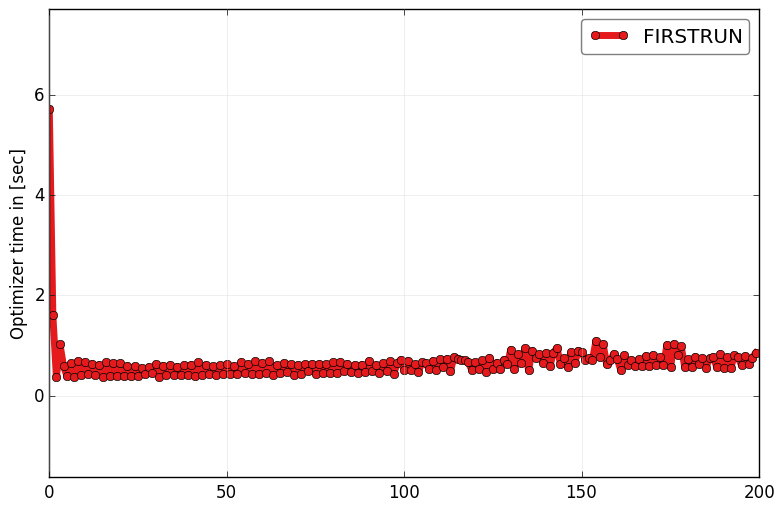

In [9]:
from IPython.display import Image
Image(filename='../results/Plots/OptimizerOverhead_622.png') 

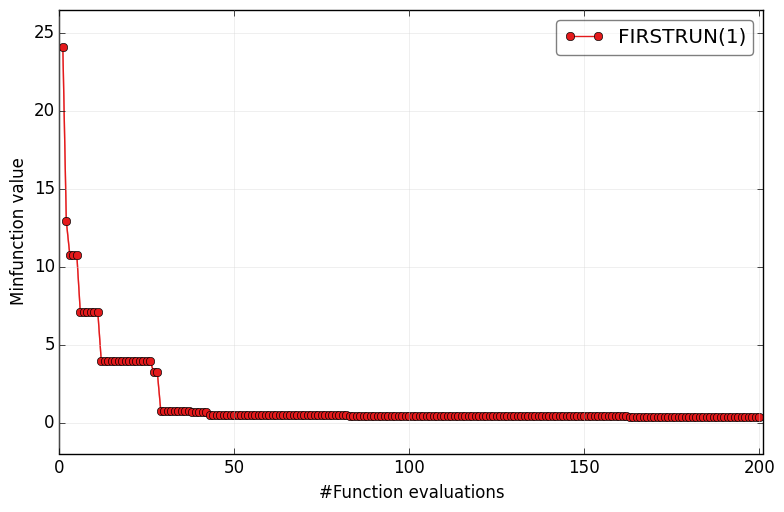

In [10]:
from IPython.display import Image
Image(filename='../results/Plots/TraceWithStd_perEval_622.png') 

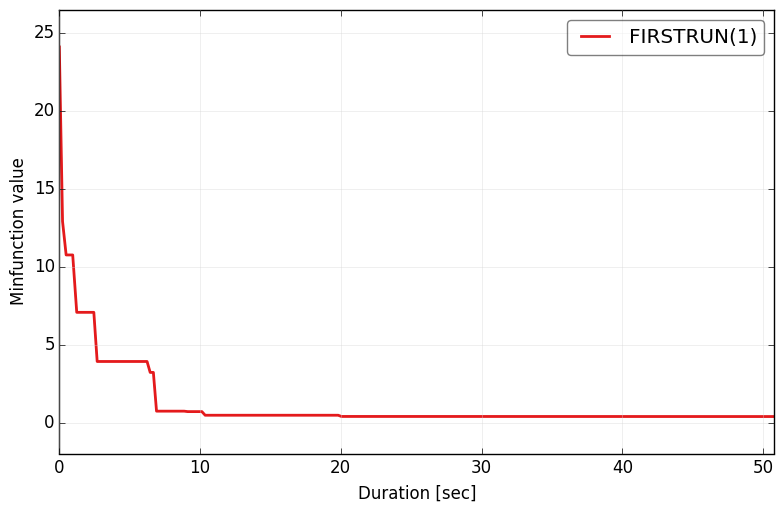

In [11]:
from IPython.display import Image
Image(filename='../results/Plots/TraceWithStd_perTime_622.png') 

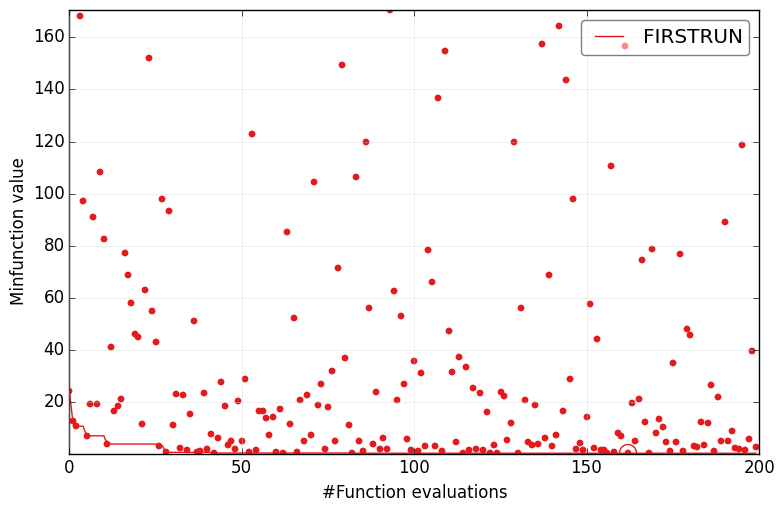

In [12]:
from IPython.display import Image
Image(filename='../results/Plots/plotTrace_622.png') 

In [ ]:
# %load ../results/Plots/statistics_622.txt
  FIRSTRUN: 1 experiment(s)
Unpaired t-tests-----------------------------------------------------
Best Value-----------------------------------------------------------
  FIRSTRUN:    0.41237 (min:    0.41237, max:    0.41237, std: 0.000)
Needed Trials--------------------------------------------------------
  FIRSTRUN:  162.00000 (min:  162.00000, max:  162.00000, std: 0.000)
------------------------------------------------------------------------
